<a href="https://colab.research.google.com/github/pandian-ra/EVA4_Session6/blob/master/L1_Weight_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        
        # CONVOLUTION BLOCK 2
        self.convblock22 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(22),
            nn.Dropout(dropout_value)
        ) # output_size = 4


        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock22(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
           Conv2d-11           [-1, 10, 10, 10]             900
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
# LAMDA = 0.001
def train(model, device, train_loader, optimizer, epoch, LAMDA):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    regularization_loss = 0
    for param in model.parameters():
        regularization_loss += torch.sum(abs(param))
 
    classify_loss = criterion(y_pred,target)
    # loss = F.nll_loss(y_pred, target)
    loss = classify_loss + LAMDA * regularization_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR
train_lossesL2 = []
test_lossesL2 = []
train_accL2 = []
test_accL2 = []

for weightInt in range(1,10):
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    weightDecimal = weightInt/10000
    print("Weight :", weightDecimal)
    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    EPOCHS = 10
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch,weightDecimal)
        # scheduler.step()
        test(model, device, test_loader)

    train_lossesL2.append(train_losses)
    test_lossesL2.append(test_losses)
    train_accL2.append(train_acc)
    test_accL2.append(test_acc)
   

  0%|          | 0/469 [00:00<?, ?it/s]

Weight : 0.0001
EPOCH: 0


Loss=0.1269024759531021 Batch_id=468 Accuracy=90.33: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.0872768983244896 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:24<00:00, 19.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.12138187140226364 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.08830292522907257 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.08554469794034958 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.10481145977973938 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.09092193841934204 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.10843463242053986 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:24<00:00, 23.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.09193677455186844 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.09271886944770813 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9915/10000 (99.15%)

Weight : 0.0002
EPOCH: 0


Loss=0.275951087474823 Batch_id=468 Accuracy=90.47: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.16221870481967926 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.19798371195793152 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.14618940651416779 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


Loss=0.17041143774986267 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:25<00:00, 18.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.2248259037733078 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.15210199356079102 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.159977525472641 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.13876409828662872 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.1075231060385704 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

Weight : 0.0003
EPOCH: 0


Loss=0.25678372383117676 Batch_id=468 Accuracy=90.12: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9792/10000 (97.92%)

EPOCH: 1


Loss=0.18218937516212463 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:24<00:00, 18.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.147501140832901 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9824/10000 (98.24%)

EPOCH: 3


Loss=0.16102778911590576 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.2193858027458191 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9795/10000 (97.95%)

EPOCH: 5


Loss=0.15366721153259277 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9874/10000 (98.74%)

EPOCH: 6


Loss=0.19101738929748535 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.21417972445487976 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Loss=0.14622381329536438 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9868/10000 (98.68%)

EPOCH: 9


Loss=0.19671623408794403 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:23<00:00, 22.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9877/10000 (98.77%)

Weight : 0.0004
EPOCH: 0


Loss=0.3012903332710266 Batch_id=468 Accuracy=90.83: 100%|██████████| 469/469 [00:24<00:00, 25.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.24096789956092834 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:24<00:00, 19.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.20644541084766388 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.2380538284778595 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.21277889609336853 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.2063256800174713 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:23<00:00, 25.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.2065848410129547 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9815/10000 (98.15%)

EPOCH: 7


Loss=0.16197875142097473 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:24<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9879/10000 (98.79%)

EPOCH: 8


Loss=0.2592132091522217 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9881/10000 (98.81%)

EPOCH: 9


Loss=0.22408699989318848 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9882/10000 (98.82%)

Weight : 0.0005
EPOCH: 0


Loss=0.32970285415649414 Batch_id=468 Accuracy=90.72: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0740, Accuracy: 9799/10000 (97.99%)

EPOCH: 1


Loss=0.25221139192581177 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9818/10000 (98.18%)

EPOCH: 2


Loss=0.2101488709449768 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.24621927738189697 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:24<00:00, 26.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9805/10000 (98.05%)

EPOCH: 4


Loss=0.2762465178966522 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.20776055753231049 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.1746901273727417 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.17467142641544342 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9833/10000 (98.33%)

EPOCH: 8


Loss=0.21497546136379242 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9816/10000 (98.16%)

EPOCH: 9


Loss=0.1711120754480362 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

Weight : 0.0006
EPOCH: 0


Loss=0.38218608498573303 Batch_id=468 Accuracy=89.24: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9772/10000 (97.72%)

EPOCH: 1


Loss=0.2728026807308197 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0864, Accuracy: 9751/10000 (97.51%)

EPOCH: 2


Loss=0.2990277409553528 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9811/10000 (98.11%)

EPOCH: 3


Loss=0.2773784399032593 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:24<00:00, 23.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9845/10000 (98.45%)

EPOCH: 4


Loss=0.22532960772514343 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.26935023069381714 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9807/10000 (98.07%)

EPOCH: 6


Loss=0.24732470512390137 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9872/10000 (98.72%)

EPOCH: 7


Loss=0.21928313374519348 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9861/10000 (98.61%)

EPOCH: 8


Loss=0.253592848777771 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9843/10000 (98.43%)

EPOCH: 9


Loss=0.2053544670343399 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9861/10000 (98.61%)

Weight : 0.0007
EPOCH: 0


Loss=0.4068533480167389 Batch_id=468 Accuracy=89.38: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0786, Accuracy: 9793/10000 (97.93%)

EPOCH: 1


Loss=0.31740179657936096 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0920, Accuracy: 9753/10000 (97.53%)

EPOCH: 2


Loss=0.30754292011260986 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9818/10000 (98.18%)

EPOCH: 3


Loss=0.2772301137447357 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9821/10000 (98.21%)

EPOCH: 4


Loss=0.2577553391456604 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


Loss=0.34897488355636597 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:23<00:00, 25.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9831/10000 (98.31%)

EPOCH: 6


Loss=0.2618089020252228 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9829/10000 (98.29%)

EPOCH: 7


Loss=0.30840009450912476 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9830/10000 (98.30%)

EPOCH: 8


Loss=0.26991015672683716 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0764, Accuracy: 9768/10000 (97.68%)

EPOCH: 9


Loss=0.388404905796051 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9811/10000 (98.11%)

Weight : 0.0008
EPOCH: 0


Loss=0.415251225233078 Batch_id=468 Accuracy=90.72: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9785/10000 (97.85%)

EPOCH: 1


Loss=0.32041695713996887 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1085, Accuracy: 9666/10000 (96.66%)

EPOCH: 2


Loss=0.3025907874107361 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9844/10000 (98.44%)

EPOCH: 3


Loss=0.4211841821670532 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1486, Accuracy: 9498/10000 (94.98%)

EPOCH: 4


Loss=0.28793948888778687 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0733, Accuracy: 9778/10000 (97.78%)

EPOCH: 5


Loss=0.3447694182395935 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Accuracy: 9750/10000 (97.50%)

EPOCH: 6


Loss=0.30352863669395447 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.2933286726474762 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:23<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 9817/10000 (98.17%)

EPOCH: 8


Loss=0.26127713918685913 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:24<00:00, 24.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9792/10000 (97.92%)

EPOCH: 9


Loss=0.32040396332740784 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9811/10000 (98.11%)

Weight : 0.0009
EPOCH: 0


Loss=0.4473792016506195 Batch_id=468 Accuracy=89.11: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1504, Accuracy: 9550/10000 (95.50%)

EPOCH: 1


Loss=0.38816118240356445 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 9723/10000 (97.23%)

EPOCH: 2


Loss=0.3652527928352356 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.332048624753952 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1101, Accuracy: 9650/10000 (96.50%)

EPOCH: 4


Loss=0.3205912113189697 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:23<00:00, 19.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.2918996810913086 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9774/10000 (97.74%)

EPOCH: 6


Loss=0.2660253643989563 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1291, Accuracy: 9605/10000 (96.05%)

EPOCH: 7


Loss=0.29942676424980164 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9852/10000 (98.52%)

EPOCH: 8


Loss=0.31027713418006897 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9829/10000 (98.29%)

EPOCH: 9


Loss=0.32627037167549133 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:23<00:00, 24.45it/s]



Test set: Average loss: 0.1581, Accuracy: 9463/10000 (94.63%)



In [9]:
test_accL2

[[98.31, 98.65, 98.6, 99.09, 99.09, 99.15, 99.08, 99.05, 98.96, 99.15],
 [97.89, 98.47, 98.73, 98.56, 98.86, 98.88, 98.96, 98.96, 99.22, 99.15],
 [97.92, 98.49, 98.24, 98.65, 97.95, 98.74, 98.93, 98.93, 98.68, 98.77],
 [98.11, 98.47, 98.68, 98.81, 98.84, 98.72, 98.15, 98.79, 98.81, 98.82],
 [97.99, 98.18, 98.49, 98.05, 98.66, 98.96, 98.91, 98.33, 98.16, 98.76],
 [97.72, 97.51, 98.11, 98.45, 98.34, 98.07, 98.72, 98.61, 98.43, 98.61],
 [97.93, 97.53, 98.18, 98.21, 98.54, 98.31, 98.29, 98.3, 97.68, 98.11],
 [97.85, 96.66, 98.44, 94.98, 97.78, 97.5, 98.4, 98.17, 97.92, 98.11],
 [95.5, 97.23, 98.05, 96.5, 98.46, 97.74, 96.05, 98.52, 98.29, 94.63]]

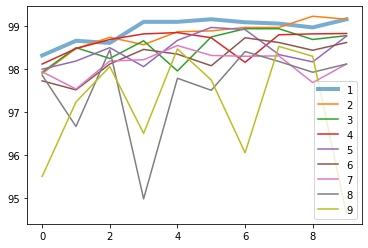

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(test_accL2[0], linewidth = 4, alpha = 0.6)
plt.plot(test_accL2[1])
plt.plot(test_accL2[2])
plt.plot(test_accL2[3])
plt.plot(test_accL2[4])
plt.plot(test_accL2[5])
plt.plot(test_accL2[6])
plt.plot(test_accL2[7])
plt.plot(test_accL2[8])
plt.legend(["1","2","3","4","5","6","7","8","9"])
plt.show()

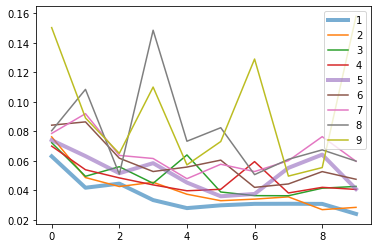

In [17]:
plt.plot(test_lossesL2[0], linewidth = 4, alpha = 0.6)
plt.plot(test_lossesL2[1])
plt.plot(test_lossesL2[2])
plt.plot(test_lossesL2[3])
plt.plot(test_lossesL2[4],linewidth = 4 ,alpha=0.6)  
plt.plot(test_lossesL2[5])
plt.plot(test_lossesL2[6])
plt.plot(test_lossesL2[7])
plt.plot(test_lossesL2[8])
plt.legend(["1","2","3","4","5","6","7","8","9"])
plt.show()

From the above graph, It's clear that 0.0001 is the best Lamda value

In [0]:
criterion = nn.CrossEntropyLoss()
batch_size = 128

In [0]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [35]:

true,pred,image,true_wrong,pred_wrong = test(test_loader)


tensor(0.9797, device='cuda:0', dtype=torch.float64) 0.030325409241758958


In [0]:
def wrong_plot(true,ima,pred,encoder,inv_normalize,n_figures ):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(10, 10), nrows = n_row, ncols=5)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+str(c.item()) + ',' +'P:'+str(w.item())
        f = 'A:'+str(correct) + ',' +'P:'+str(wrong)
        # image = image.numpy().transpose(1,2,0)
        image = image.squeeze()
        im = ax.imshow(image, cmap='gray', interpolation='none')
        ax.set_title(f)
        ax.axis('off')
    plt.show()

Classes in order Actual and Predicted


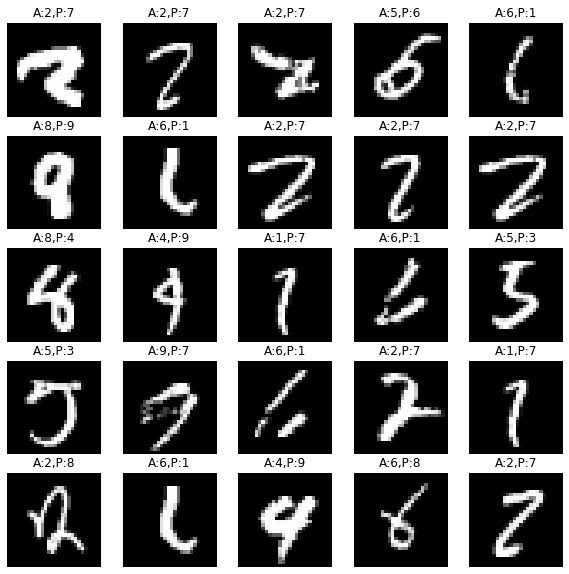

In [99]:
wrong_plot(true_wrong,image,pred_wrong,test_loader.targets,None,25)
